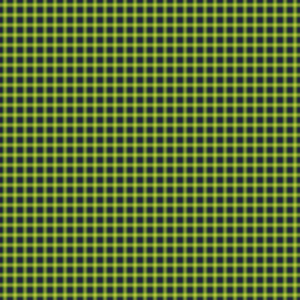

In [2]:
import random
import io
import base64
from collections import namedtuple
import numpy as np
from PIL import Image
from IPython import display


def blend_many(ims):
    """
    Blends a sequence of images.
    """
    current, *ims = ims
    for i, im in enumerate(ims):
        current = Image.blend(current, im, 1/(i+2))
    return current
def blend_tiles(choices, tiles):
    """
    Given a list of states (True if ruled out, False if not) for each tile,
    and a list of tiles, return a blend of all the tiles that haven't been
    ruled out.
    """
    to_blend = [tiles[i].bitmap for i in range(len(choices)) if choices[i]]
    return blend_many(to_blend)
def show_state(potential, tiles):
    """
    Given a list of states for each tile for each position of the image, return
    an image representing the state of the global image.
    """
    rows = []
    for row in potential:
        rows.append([np.asarray(blend_tiles(t, tiles)) for t in row])

    rows = np.array(rows)
    n_rows, n_cols, tile_height, tile_width, _ = rows.shape
    images = np.swapaxes(rows, 1, 2)
    return Image.fromarray(images.reshape(n_rows*tile_height, n_cols*tile_width, 4))

def find_true(array):
    """
    Like np.nonzero, except it makes sense.
    """
    transform = int if len(np.asarray(array).shape) == 1 else tuple
    return list(map(transform, np.transpose(np.nonzero(array))))

straight_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAMklEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMowrpqxAAjKLGXfWE8ZAAAAAASUVORK5CYII=')))
bend_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAANklEQVQYlWNQVrT9TwxmIFmheaImXoyisGmVBk6MofDwFSesmHKFRFvdtEoDv2fQFWINHnwKAQHMxl1/fce/AAAAAElFTkSuQmCC')))
blank_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAFElEQVQYlWNQVrT9TwxmGFVIX4UAoDOWARI9hF0AAAAASUVORK5CYII=')))
cross_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAU0lEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMRCs0T9T8D8PYFMIwQ9Mqjf/IGFkhMmaASRDCxCsk2mqiPUP1cAQAKI/idfPNuccAAAAASUVORK5CYII=')))
t_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAWUlEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMRCs0T9T8D8PYFMIwQ9Mqjf/IGFkhMmaASRDCxCtEtwIXRvEMPgwPHkKYaIUAow/UaQFDAc4AAAAASUVORK5CYII=')))

Tile = namedtuple('Tile', ('name', 'bitmap', 'sides', 'weight'))

tiles = [
    Tile('straight_ud', straight_image,
         [False, True, False, True], 1/2),
    Tile('straight_lr', straight_image.transpose(Image.ROTATE_90),
         [True, False, True, False], 1/2),
    Tile('bend_br', bend_image,
         [True, False, False, True], 1/4),
    Tile('bend_tr', bend_image.transpose(Image.ROTATE_90),
         [True, True, False, False], 1/4),
    Tile('bend_tl', bend_image.transpose(Image.ROTATE_180),
         [False, True, True, False], 1/4),
    Tile('bend_bl', bend_image.transpose(Image.ROTATE_270),
         [False, False, True, True], 1/4),
    Tile('t_u', t_image,
         [True, True, True, False], 1/4),
    Tile('t_l', t_image.transpose(Image.ROTATE_90),
         [False, True, True, True], 1/4),
    Tile('t_d', t_image.transpose(Image.ROTATE_180),
         [True, False, True, True], 1/4),
    Tile('t_r', t_image.transpose(Image.ROTATE_270),
         [True, True, False, True], 1/4),
    Tile('blank', blank_image,
         [False, False, False, False], 1),
    Tile('cross', cross_image,
         [True, True, True, True], 1)
]

weights = np.asarray([t.weight for t in tiles])
potential = np.full((30, 30, len(tiles)), True)
display.display(show_state(potential, tiles))


def run_iteration(old_potential):
    potential = old_potential.copy()
    to_collapse = location_with_fewest_choices(potential) #3
    if to_collapse is None:                               #1
        raise StopIteration()
    elif not np.any(potential[to_collapse]):              #2
        raise Exception(f"No choices left at {to_collapse}")
    else:                                                 #4 ↓
        nonzero = find_true(potential[to_collapse])
        tile_probs = weights[nonzero]/sum(weights[nonzero])
        selected_tile = np.random.choice(nonzero, p=tile_probs)
        potential[to_collapse] = False
        potential[to_collapse][selected_tile] = True
        propagate(potential, to_collapse)                 #5
    return potential

def location_with_fewest_choices(potential):
    num_choices = np.sum(potential, axis=2, dtype='float32')
    num_choices[num_choices == 1] = np.inf
    candidate_locations = find_true(num_choices == num_choices.min())
    location = random.choice(candidate_locations)
    if num_choices[location] == np.inf:
        return None
    return location

from enum import Enum, auto

class Direction(Enum):
    RIGHT = 0; UP = 1; LEFT = 2; DOWN = 3

    def reverse(self):
        return {Direction.RIGHT: Direction.LEFT,
                Direction.LEFT: Direction.RIGHT,
                Direction.UP: Direction.DOWN,
                Direction.DOWN: Direction.UP}[self]

def neighbors(location, height, width):
    res = []
    x, y = location
    if x != 0:
        res.append((Direction.UP, x-1, y))
    if y != 0:
        res.append((Direction.LEFT, x, y-1))
    if x < height - 1:
        res.append((Direction.DOWN, x+1, y))
    if y < width - 1:
        res.append((Direction.RIGHT, x, y+1))
    return res

def propagate(potential, start_location):
    height, width = potential.shape[:2]
    needs_update = np.full((height, width), False)
    needs_update[start_location] = True
    while np.any(needs_update):
        needs_update_next = np.full((height, width), False)
        locations = find_true(needs_update)
        for location in locations:
            possible_tiles = [tiles[n] for n in find_true(potential[location])]
            for neighbor in neighbors(location, height, width):
                neighbor_direction, neighbor_x, neighbor_y = neighbor
                neighbor_location = (neighbor_x, neighbor_y)
                was_updated = add_constraint(potential, neighbor_location,
                                             neighbor_direction, possible_tiles)
                needs_update_next[location] |= was_updated
        needs_update = needs_update_next

def add_constraint(potential, location, incoming_direction, possible_tiles):
    neighbor_constraint = {t.sides[incoming_direction.value] for t in possible_tiles}
    outgoing_direction = incoming_direction.reverse()
    changed = False
    for i_p, p in enumerate(potential[location]):
        if not p:
            continue
        if tiles[i_p].sides[outgoing_direction.value] not in neighbor_constraint:
            potential[location][i_p] = False
            changed = True
    if not np.any(potential[location]):
        raise Exception(f"No patterns left at {location}")
    return changed

p = potential
images = [show_state(p, tiles)]
while True:
    try:
        p = run_iteration(p)
        images.append(show_state(p, tiles))  # Move me for speed
    except StopIteration as e:
        break
    except Exception as e:
        print(e)
        break

out = io.BytesIO()
images[0].save(out, format='gif', save_all=True, append_images=images[1:],
               duration=50, loop=0)

In [ ]:
import base64
from IPython import display
display.HTML('<img src="data:image/gif;base64,{0}">'
             .format(base64.b64encode(out.getvalue()).decode('utf8')))
